In [78]:
#https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('boulderdata.csv')

def one_hot_encode_col(df: pd.DataFrame, col: str):
    df = pd.concat([df, pd.get_dummies(df[col])], axis=1)
    df.drop(col, axis=1, inplace=True)
    return df

df['current_time'] = pd.to_datetime(df['current_time'])
df['weekday'] = df['current_time'].apply(lambda x: x.strftime('%A'))
df['time'] = df['current_time'].apply(lambda x: x.hour + x.minute/60)
df = df.drop('current_time', axis=1)

# one-hot encode the categorical variables
df = one_hot_encode_col(df, 'gym_name')
df = one_hot_encode_col(df, 'weekday')
df = one_hot_encode_col(df, 'weather_status')

# join occupancy and waiting into a single column
df['occupancy'] = df.apply(lambda r: r.occupancy + r.waiting/100, axis=1)
df.drop('waiting', axis=1, inplace=True)

# extract y from df
y = df['occupancy'].to_numpy()
df.drop('occupancy', axis=1, inplace=True)
X = df.to_numpy()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [4]:
print(X_train.shape, X_test.shape)

(1785, 21) (199, 21)


In [23]:
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', verbosity=1)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [24]:
score = model.score(X_train, y_train)
print("Training score: ", score)

from sklearn.model_selection import cross_val_score, KFold
scores = cross_val_score(model, X_train, y_train, cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Training score:  0.9725612939674002
Mean cross-validation score: 0.74


In [25]:
from sklearn.metrics import mean_squared_error
ypred = model.predict(X_test)
mse = mean_squared_error(y_test, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse**(1/2.0)))

MSE: 162.05
RMSE: 12.73


In [46]:
yhats = model.predict(X_test)
error = sum(abs(y_test - yhats))
print(f"Error={error/X_train.shape[0]}")

Error=0.9573331448397382


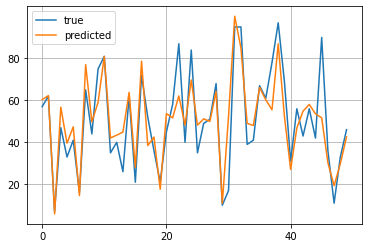

In [50]:
beg, end = 50, 100

fig = plt.figure()
ax = fig.gca()
ax.set_xticks(np.arange(0, end-beg, 20))
ax.set_yticks(np.arange(0, 100, 20))
plt.plot(y_test[beg:end])
plt.plot(yhats[beg:end])
plt.legend(['true', 'predicted'], loc='upper left')
plt.grid()
plt.show()